<a href="https://colab.research.google.com/github/yashaswinirudrapaati20/AGS/blob/main/AutomatedGradingSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

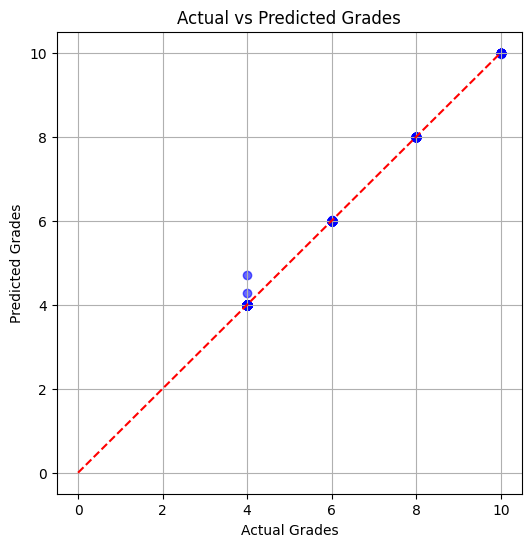

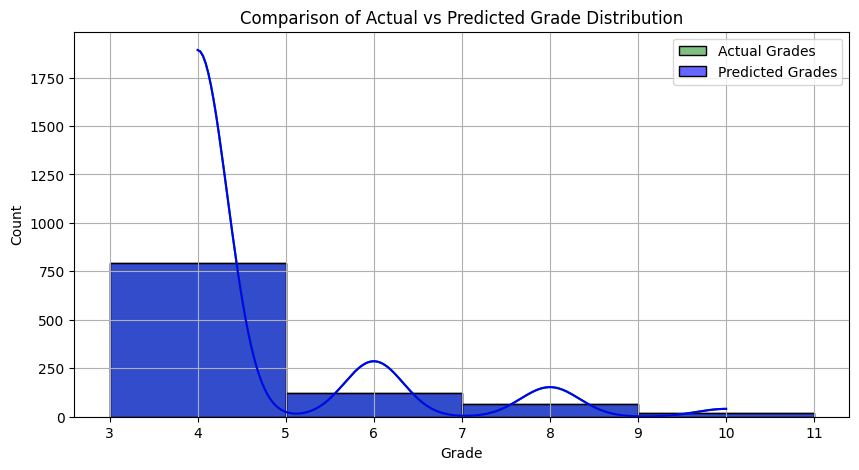

📊 Model Evaluation Summary
----------------------------------------
🔹 Mean Squared Error (MSE): 0.0006
🔹 R-squared (R²): 0.9997
🔹 Sample size: 994
----------------------------------------


In [3]:
# Install required libraries (uncomment if running in a fresh environment)
# !pip install -U datasets sentence-transformers scikit-learn matplotlib seaborn torch

import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load the dataset
dataset = load_dataset('nkazi/SciEntsBank')

# Step 2: Load the Sentence-BERT model for embedding
# Device selection is automatic; you can specify device if needed
model = SentenceTransformer('all-MiniLM-L6-v2')  # [2][3][5]

# Step 3: Function to convert similarity score to a grade
def similarity_to_grade(similarity):
    if similarity >= 0.9:
        return 10
    elif similarity >= 0.8:
        return 8
    elif similarity >= 0.7:
        return 6
    else:
        return 4

# Step 4: Create features and labels from the dataset
X = []
y = []

for example in dataset["train"]:
    question = example["question"]
    reference_answer = example["reference_answer"]
    student_answer = example["student_answer"]

    # Encode the sentences using Sentence-BERT
    sentences = [question, reference_answer, student_answer]
    embeddings = model.encode(sentences)

    # Calculate cosine similarity between student answer and reference answer
    similarity_score = cosine_similarity([embeddings[2]], [embeddings[1]])  # Student vs reference
    X.append([similarity_score[0][0]])  # Add similarity score as feature

    # Convert similarity score to a grade
    grade = similarity_to_grade(similarity_score[0][0])
    y.append(grade)  # Add grade as label

# Step 5: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 7: Predict grades using the trained model
y_pred = rf_model.predict(X_test)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 9: Visualize the predicted vs actual grades
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Actual vs Predicted Grades')
plt.grid(True)
plt.show()

# Step 10: Visualize distribution comparison between actual and predicted grades
def round_to_nearest_grade(pred):
    return min([4, 6, 8, 10], key=lambda x: abs(x - pred))

rounded_preds = [round_to_nearest_grade(p) for p in y_pred]

plt.figure(figsize=(10, 5))
sns.histplot(y_test, color='green', label='Actual Grades', kde=True, bins=[3, 5, 7, 9, 11])
sns.histplot(rounded_preds, color='blue', label='Predicted Grades', kde=True, bins=[3, 5, 7, 9, 11], alpha=0.6)
plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Comparison of Actual vs Predicted Grade Distribution")
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Print model performance summary
print("📊 Model Evaluation Summary")
print("-" * 40)
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 R-squared (R²): {r2:.4f}")
print(f"🔹 Sample size: {len(y_test)}")
print("-" * 40)
